In [312]:
import pandas as pd
from sklearn.preprocessing import Normalizer,StandardScaler
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,accuracy_score,classification_report
from datetime import datetime,timedelta

In [263]:
df=pd.read_csv("dataset_general_etl.csv")
df_country=pd.read_csv("dataset_country_etl.csv")
df=pd.merge(df,df_country,on="id_country",how="inner").drop(columns="id_country")
df

,date,time,latitude,longitude,depth,mag,updated,place,horizontalError,country
0,2013-01-01,2013-01-01 03:32:13.010000+00:00,40.353,141.547,107,4.3,2014-11-07 01:49:43.034000+00:00,"16 km SSE of Hachinohe, Japan",0.00,Japan
1,2013-01-01,2013-01-01 09:19:16.080000+00:00,26.997,127.380,93,4.8,2015-03-24 02:18:11.090000+00:00,"73 km NW of Nago, Japan",0.00,Japan
2,2013-01-02,2013-01-02 10:31:02.520000+00:00,29.344,142.216,35,4.9,2014-11-07 01:49:44.587000+00:00,"Izu Islands, Japan region",0.00,Japan
3,2013-01-02,2013-01-02 12:00:12.310000+00:00,42.159,143.314,68,4.2,2014-11-07 01:49:44.604000+00:00,"80 km ESE of Shizunai-furukawach?, Japan",0.00,Japan
4,2013-01-02,2013-01-02 20:31:04.080000+00:00,33.461,141.905,5,4.6,2014-11-07 01:49:44.878000+00:00,"237 km SE of Katsuura, Japan",0.00,Japan
...,...,...,...,...,...,...,...,...,...,...
36372,2023-06-24,2023-06-24 14:23:53+00:00,-9.560,-78.950,45,4.0,2023-06-24 14:23:53+00:00,territory of Peru,0.00,Peru
36373,2023-06-25,2023-06-25 01:35:56+00:00,-15.600,-74.150,92,4.9,2023-06-25 02:02:21.040000+00:00,Near the coast of southern Peru,9.64,Peru
36374,2023-06-25,2023-06-25 13:26:50+00:00,-18.230,-71.740,28,4.4,2023-06-25 13:43:20.040000+00:00,"63 km SSW of Pacocha, Peru",8.03,Peru
36375,2023-06-26,2023-06-26 15:08:23+00:00,-9.890,-75.580,22,4.0,2023-06-26 15:08:23+00:00,territory of Peru,0.00,Peru


In [264]:
df.shape,df.columns

((36377, 10),
 Index(['date', 'time', 'latitude', 'longitude', 'depth', 'mag', 'updated',
        'place', 'horizontalError', 'country'],
       dtype='object'))

#### Preprocesamiento de Datos

In [265]:
# Eliminación de columnas que no aportan análisis en el modelo
df_view=df.copy()
df.drop(columns=["date","time","updated","place","horizontalError","country"],inplace=True)

# Codificación de la variable categórica nominal 'country'
#df=pd.get_dummies(df)

# Escalado de las variables numéricas
columns=["latitude","longitude","depth","mag"]
ss=StandardScaler()
df[columns]=ss.fit_transform(df[columns])

# Visualización del preprocesamiento
df

,latitude,longitude,depth,mag
0,0.397131,1.364061,0.842124,-0.261381
1,-0.137593,1.253572,0.640253,0.813654
2,-0.043628,1.369278,-0.196069,1.028661
3,0.469437,1.377842,0.279769,-0.476388
4,0.121201,1.366853,-0.628650,0.383640
...,...,...,...,...
36372,-1.601200,-0.355606,-0.051876,-0.906402
36373,-1.843019,-0.318171,0.625834,1.028661
36374,-1.948315,-0.299375,-0.297005,-0.046374
36375,-1.614412,-0.329323,-0.383521,-0.906402


In [266]:
for c in df.columns:
    print(df[c].min(),df[c].max())

-2.155186031798403 1.6295924101429549
-1.1436709729517298 1.663856273827172
-0.7584243208034915 10.012834147401591
-4.346514329760807 7.69387874180664


#### Definición del algoritmo

In [267]:
X=df.values
X

array([[ 0.39713133,  1.36406085,  0.84212413, -0.26138097],
       [-0.13759333,  1.25357172,  0.64025315,  0.81365413],
       [-0.04362816,  1.36927841, -0.19606946,  1.02866115],
       ...,
       [-1.94831453, -0.29937483, -0.29700495, -0.04637395],
       [-1.61441189, -0.32932318, -0.38352108, -0.90640202],
       [-1.87584885, -0.31575283, -0.32584366,  0.81365413]])

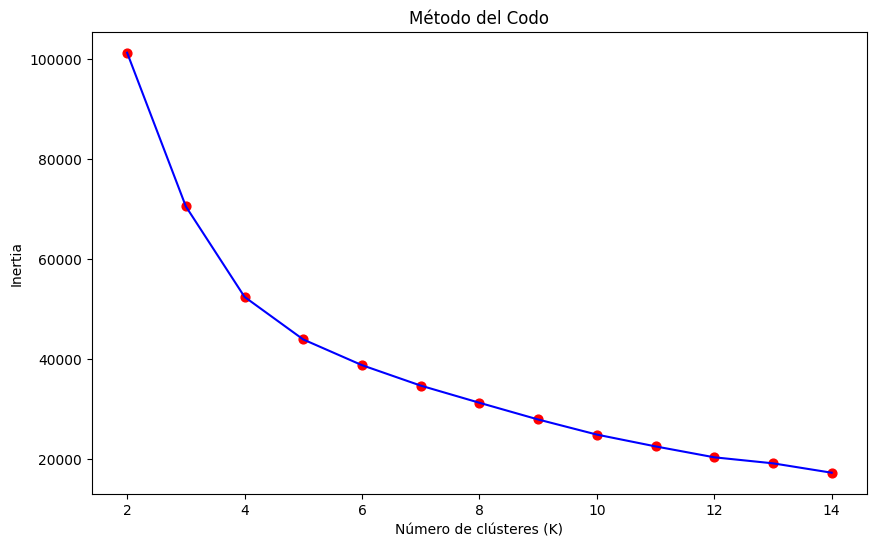

In [268]:
# Método del 'elbow'
K=np.arange(2,15)
inertia=[]
for k in K:
    km=KMeans(n_clusters=k,n_init=10,random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

# Graficando
plt.figure(figsize=(10,6))
plt.scatter(K,inertia,s=40,c="red")
plt.plot(K,inertia,c="blue")
plt.xlabel("Número de clústeres (K)")
plt.ylabel("Inertia")
plt.title("Método del Codo");

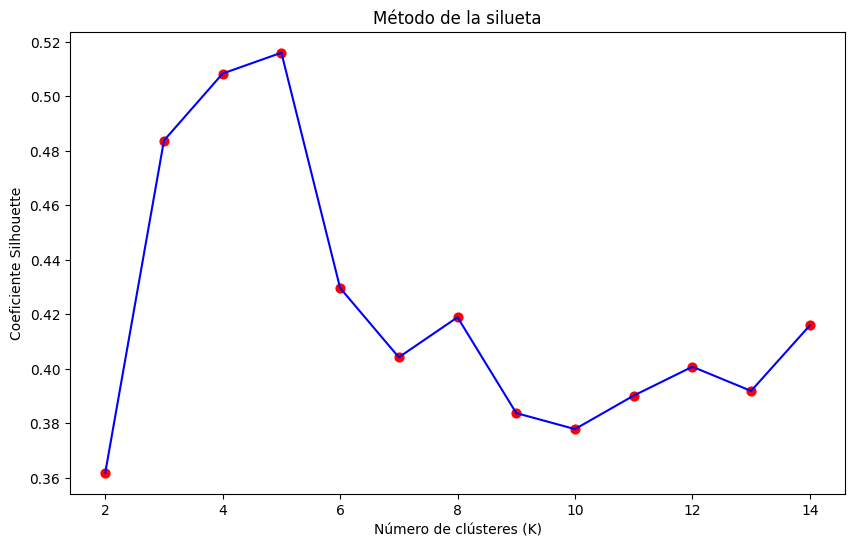

In [269]:
# Método de la 'Silhouetta'
K=np.arange(2,15)
silhouette=[]
for k in K:
    km=KMeans(n_clusters=k,n_init=10,random_state=42)
    km.fit(X)
    ss=silhouette_score(X,km.labels_)
    silhouette.append(ss)

# Graficando
plt.figure(figsize=(10,6))
plt.scatter(K,silhouette,s=40,c="red")
plt.plot(K,silhouette,c="blue")
plt.xlabel("Número de clústeres (K)")
plt.ylabel("Coeficiente Silhouette")
plt.title("Método de la silueta");

* Conclusión: a partir de ambos gráficos se infiere que el K óptimo es `5`

In [279]:
# Aplicación del algoritmo KMeans
km=KMeans(n_clusters=3,n_init=10,random_state=42)
km.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [280]:
km.labels_

array([1, 1, 1, ..., 2, 2, 2])

In [281]:
km.cluster_centers_

array([[ 0.70405355, -0.86340801, -0.33254096, -0.43910687],
       [ 0.18156162,  1.34876949,  0.18616934,  0.40879675],
       [-1.66902465, -0.3326759 ,  0.37656814,  0.250476  ]])

In [282]:
df_view["cluster"]=km.labels_
df_view

,date,time,latitude,longitude,depth,mag,updated,place,horizontalError,country,cluster
0,2013-01-01,2013-01-01 03:32:13.010000+00:00,40.353,141.547,107,4.3,2014-11-07 01:49:43.034000+00:00,"16 km SSE of Hachinohe, Japan",0.00,Japan,1
1,2013-01-01,2013-01-01 09:19:16.080000+00:00,26.997,127.380,93,4.8,2015-03-24 02:18:11.090000+00:00,"73 km NW of Nago, Japan",0.00,Japan,1
2,2013-01-02,2013-01-02 10:31:02.520000+00:00,29.344,142.216,35,4.9,2014-11-07 01:49:44.587000+00:00,"Izu Islands, Japan region",0.00,Japan,1
3,2013-01-02,2013-01-02 12:00:12.310000+00:00,42.159,143.314,68,4.2,2014-11-07 01:49:44.604000+00:00,"80 km ESE of Shizunai-furukawach?, Japan",0.00,Japan,1
4,2013-01-02,2013-01-02 20:31:04.080000+00:00,33.461,141.905,5,4.6,2014-11-07 01:49:44.878000+00:00,"237 km SE of Katsuura, Japan",0.00,Japan,1
...,...,...,...,...,...,...,...,...,...,...,...
36372,2023-06-24,2023-06-24 14:23:53+00:00,-9.560,-78.950,45,4.0,2023-06-24 14:23:53+00:00,territory of Peru,0.00,Peru,2
36373,2023-06-25,2023-06-25 01:35:56+00:00,-15.600,-74.150,92,4.9,2023-06-25 02:02:21.040000+00:00,Near the coast of southern Peru,9.64,Peru,2
36374,2023-06-25,2023-06-25 13:26:50+00:00,-18.230,-71.740,28,4.4,2023-06-25 13:43:20.040000+00:00,"63 km SSW of Pacocha, Peru",8.03,Peru,2
36375,2023-06-26,2023-06-26 15:08:23+00:00,-9.890,-75.580,22,4.0,2023-06-26 15:08:23+00:00,territory of Peru,0.00,Peru,2


In [283]:
for i in np.unique(km.labels_):
    print(f"cluster {i}: ",df_view[df_view.cluster==i].mag.min(),df_view[df_view.cluster==i].mag.max())

cluster 0:  2.4 6.1
cluster 1:  3.6 7.9
cluster 2:  3.0 8.0


In [284]:
df_view[(df_view.cluster==1)&(df_view.country!="Japan")]

,date,time,latitude,longitude,depth,mag,updated,place,horizontalError,country,cluster
10954,2013-01-04,2013-01-04 20:35:09.740000+00:00,50.6370,179.0330,16,4.3,2019-05-13 22:44:01.015000+00:00,"Rat Islands, Aleutian Islands, Alaska",0.00,USA,1
10955,2013-01-05,2013-01-05 02:06:01.180000+00:00,51.5230,176.9470,42,4.0,2019-05-13 22:44:19.354000+00:00,"296 km ESE of Attu Station, Alaska",0.00,USA,1
10957,2013-01-05,2013-01-05 08:58:14.957000+00:00,55.2280,-134.8591,9,7.5,2022-05-03 16:02:50.203000+00:00,"110 km SW of Edna Bay, Alaska",0.00,USA,1
10980,2013-01-05,2013-01-05 20:33:01.750000+00:00,52.8790,171.8700,15,4.2,2014-11-07 01:49:46.899000+00:00,"88 km W of Attu Station, Alaska",0.00,USA,1
10988,2013-01-08,2013-01-08 09:21:11.820000+00:00,51.4380,179.5930,12,4.2,2019-05-13 22:46:56.065000+00:00,"265 km WSW of Adak, Alaska",0.00,USA,1
...,...,...,...,...,...,...,...,...,...,...,...
28313,2023-06-14,2023-06-14 12:15:34.042000+00:00,50.3167,178.9679,10,4.1,2023-06-29 07:14:35.040000+00:00,"Rat Islands, Aleutian Islands, Alaska",7.09,USA,1
28314,2023-06-14,2023-06-14 18:48:24.855000+00:00,50.3579,179.1013,10,4.2,2023-06-22 15:06:39.040000+00:00,"Rat Islands, Aleutian Islands, Alaska",6.10,USA,1
28333,2023-06-20,2023-06-20 00:59:18.364000+00:00,50.2153,178.6971,11,4.2,2023-06-22 20:21:35.648000+00:00,"Rat Islands, Aleutian Islands, Alaska",0.00,USA,1
28336,2023-06-22,2023-06-22 00:01:29.702000+00:00,51.0754,179.7795,31,4.1,2023-06-27 00:41:13.040000+00:00,"264 km WSW of Adak, Alaska",4.08,USA,1


#### Aplicación considerando solo la variable `mag` para el KMeans

In [285]:
X2=df.mag.values.reshape(-1,1)
X2

array([[-0.26138097],
       [ 0.81365413],
       [ 1.02866115],
       ...,
       [-0.04637395],
       [-0.90640202],
       [ 0.81365413]])

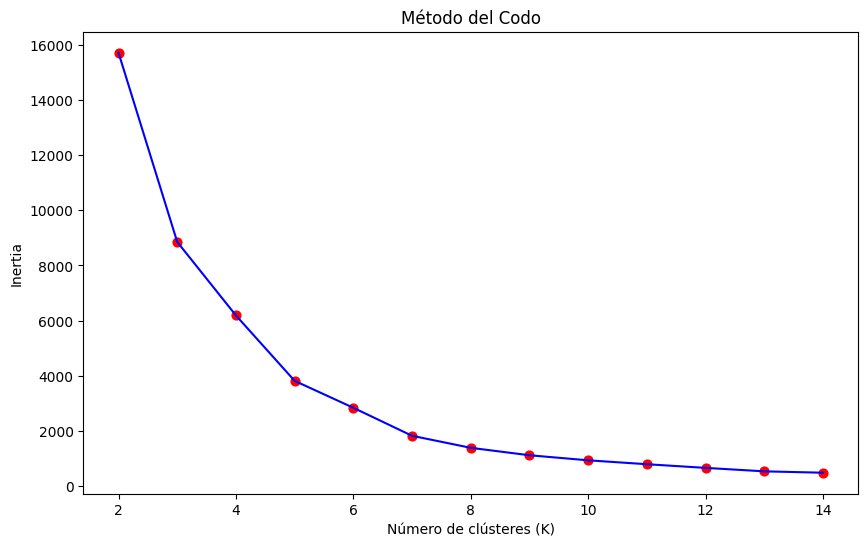

In [286]:
# Método del 'elbow'
K=np.arange(2,15)
inertia=[]
for k in K:
    km=KMeans(n_clusters=k,n_init=10,random_state=42)
    km.fit(X2)
    inertia.append(km.inertia_)

# Graficando
plt.figure(figsize=(10,6))
plt.scatter(K,inertia,s=40,c="red")
plt.plot(K,inertia,c="blue")
plt.xlabel("Número de clústeres (K)")
plt.ylabel("Inertia")
plt.title("Método del Codo");

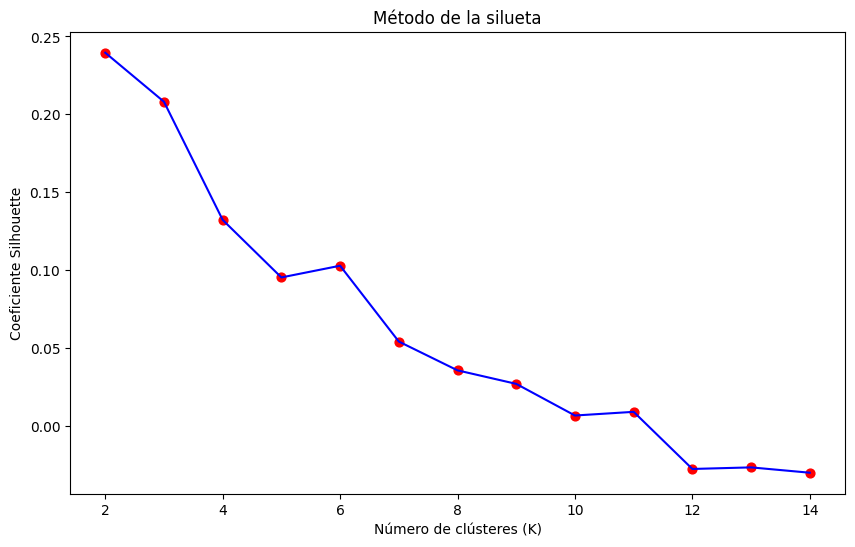

In [287]:
# Método de la 'Silhouetta'
K=np.arange(2,15)
silhouette=[]
for k in K:
    km=KMeans(n_clusters=k,n_init=10,random_state=42)
    km.fit(X2)
    ss=silhouette_score(X,km.labels_)
    silhouette.append(ss)

# Graficando
plt.figure(figsize=(10,6))
plt.scatter(K,silhouette,s=40,c="red")
plt.plot(K,silhouette,c="blue")
plt.xlabel("Número de clústeres (K)")
plt.ylabel("Coeficiente Silhouette")
plt.title("Método de la silueta");

In [288]:
# Según las gráficas 3 clusters es aceptable
km=KMeans(n_clusters=3,n_init=10,random_state=42)
km.fit(X2)

KMeans(n_clusters=3, n_init=10, random_state=42)

In [289]:
km.labels_

array([2, 1, 1, ..., 1, 2, 1])

In [292]:
df_view["cluster"]=km.labels_
df_view

,date,time,latitude,longitude,depth,mag,updated,place,horizontalError,country,cluster
0,2013-01-01,2013-01-01 03:32:13.010000+00:00,40.353,141.547,107,4.3,2014-11-07 01:49:43.034000+00:00,"16 km SSE of Hachinohe, Japan",0.00,Japan,2
1,2013-01-01,2013-01-01 09:19:16.080000+00:00,26.997,127.380,93,4.8,2015-03-24 02:18:11.090000+00:00,"73 km NW of Nago, Japan",0.00,Japan,1
2,2013-01-02,2013-01-02 10:31:02.520000+00:00,29.344,142.216,35,4.9,2014-11-07 01:49:44.587000+00:00,"Izu Islands, Japan region",0.00,Japan,1
3,2013-01-02,2013-01-02 12:00:12.310000+00:00,42.159,143.314,68,4.2,2014-11-07 01:49:44.604000+00:00,"80 km ESE of Shizunai-furukawach?, Japan",0.00,Japan,2
4,2013-01-02,2013-01-02 20:31:04.080000+00:00,33.461,141.905,5,4.6,2014-11-07 01:49:44.878000+00:00,"237 km SE of Katsuura, Japan",0.00,Japan,1
...,...,...,...,...,...,...,...,...,...,...,...
36372,2023-06-24,2023-06-24 14:23:53+00:00,-9.560,-78.950,45,4.0,2023-06-24 14:23:53+00:00,territory of Peru,0.00,Peru,2
36373,2023-06-25,2023-06-25 01:35:56+00:00,-15.600,-74.150,92,4.9,2023-06-25 02:02:21.040000+00:00,Near the coast of southern Peru,9.64,Peru,1
36374,2023-06-25,2023-06-25 13:26:50+00:00,-18.230,-71.740,28,4.4,2023-06-25 13:43:20.040000+00:00,"63 km SSW of Pacocha, Peru",8.03,Peru,1
36375,2023-06-26,2023-06-26 15:08:23+00:00,-9.890,-75.580,22,4.0,2023-06-26 15:08:23+00:00,territory of Peru,0.00,Peru,2


In [294]:
# Solo con 'mag'
for i in np.unique(km.labels_):
    print(f"cluster {i}: ",df_view[df_view.cluster==i].mag.min(),df_view[df_view.cluster==i].mag.max())

# Cluster 2: Peligrosidad baja; cluster 1: peligrosidad media; cluster 0: peligrosidad alta

cluster 0:  5.2 8.0
cluster 1:  4.4 5.1
cluster 2:  2.4 4.3


In [296]:
df["hazard"]=km.labels_
df

,latitude,longitude,depth,mag,hazard
0,0.397131,1.364061,0.842124,-0.261381,2
1,-0.137593,1.253572,0.640253,0.813654,1
2,-0.043628,1.369278,-0.196069,1.028661,1
3,0.469437,1.377842,0.279769,-0.476388,2
4,0.121201,1.366853,-0.628650,0.383640,1
...,...,...,...,...,...
36372,-1.601200,-0.355606,-0.051876,-0.906402,2
36373,-1.843019,-0.318171,0.625834,1.028661,1
36374,-1.948315,-0.299375,-0.297005,-0.046374,1
36375,-1.614412,-0.329323,-0.383521,-0.906402,2


* Aplicando el modelo de clasificación supervisado

In [299]:
# SVM Clasificación
X=df.drop(columns="hazard")
y=df.hazard

In [300]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42)

In [301]:
svc=SVC()
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)

In [306]:
# Comparando los resultados
s=pd.concat([y_test.reset_index(drop=True),pd.DataFrame(y_pred)],axis=1).rename(columns={0:"hazard_pred"})
s

,hazard,hazard_pred
0,1,1
1,1,1
2,1,1
3,2,2
4,1,1
...,...,...
9090,1,1
9091,2,2
9092,1,1
9093,1,1


In [307]:
s[s.hazard!=s.hazard_pred]

,hazard,hazard_pred
1300,1,2
1310,0,1
2915,0,1
3337,1,0


4645 3921 529


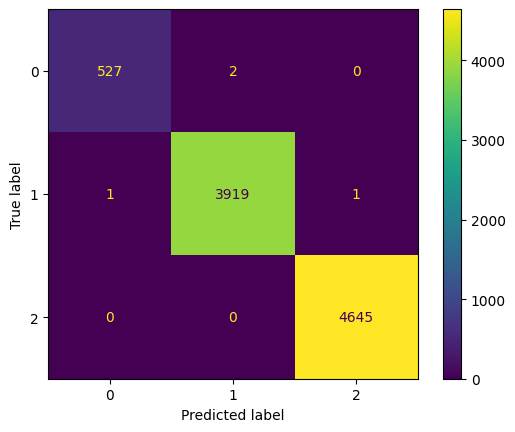

In [308]:
# Matriz de Confusión
cm=confusion_matrix(y_test,y_pred)#,labels=[1,0])
cmd=ConfusionMatrixDisplay(cm)#,display_labels=[1,0])
cmd.plot();
print(y_test[y_test==2].count(),y_test[y_test==1].count(),y_test[y_test==0].count())

In [343]:
print("Exactitud del modelo: ",accuracy_score(y_test,y_pred))
print("Reporte delmodelo: " ,classification_report(y_test,y_pred) )

Exactitud del modelo:  0.9995601979109401
Reporte delmodelo:                precision    recall  f1-score   support

           0       1.00      1.00      1.00       529
           1       1.00      1.00      1.00      3921
           2       1.00      1.00      1.00      4645

    accuracy                           1.00      9095
   macro avg       1.00      1.00      1.00      9095
weighted avg       1.00      1.00      1.00      9095



* **CONCLUSIÓN:** El modelo muestra una alta precisión general de 0.9995601979109401 y un rendimiento excelente en términos de precisión, recall y F1-score para cada clase, lo que indica una clasificación altamente precisa y confiable en todas las categorías de gravedad de los sismos.

#### Probando con datos (solo de la usgs) de cada día

In [323]:
# Lista de estados de E.E.U.U y sus abreviaturas
state = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'North Carolina', 'South Carolina', 'Colorado',
           'Connecticut', 'North Dakota', 'South Dakota', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois',
           'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
           'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey',
           'New York', 'New Mexico', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'Tennessee', 'Texas',
           'Utah', 'Vermont', 'Virginia', 'West Virginia', 'Washington', 'Wisconsin', 'Wyoming', 'District of Columbia']

abbreviation = ['AL', 'AK', 'AZ', 'AR', 'CA', 'NC', 'SC', 'CO', 'CT', 'ND', 'SD', 'DE', 'FL', 'GA', 'HI', 'ID', 'IL',
                'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
                'NY', 'NM', 'OH', 'OK', 'OR', 'PA', 'RI', 'TN', 'TX', 'UT', 'VT', 'VA', 'WV', 'WA', 'WI', 'WY', 'DC']

In [333]:
# Función para la estandarización de la magnitud
def apply_filter(df):
    filter = (df.magType == "ml") & (df.mag >= 3.3) & (df.mag <= 6.6)
    df["magType"] = df.magType.mask(filter, "mw")
    df["mag"] = df.mag.mask(filter, 0.8095 * df.mag + 1.3003)

    df["magType"] = df.magType.mask(df.magType.isin(["mww", "mwc", "mwb", "mwr"]), "mw")

    def filter2(mb):
        ms = 1.664 * mb - 3.753 if mb <= 5.9 else 2.763 * mb - 10.301
        if 3 < ms < 6.1:
            return 0.67 * ms + 2.07, True
        elif 6.2 < ms < 8.2:
            return 0.99 * ms + 0.08, True
        else:
            return mb, False
    mask = df["mag"].apply(filter2).apply(lambda x: x[1])
    df.loc[mask, "magType"] = "mw"
    df.loc[mask, "mag"] = df.loc[mask, "mag"].apply(filter2).apply(lambda x: x[0])
    
    df["depth"]=df.depth.round().astype(int)
    df["mag"]=df.mag.round(1)

    return df[df.magType=="mw"]

In [372]:
# ETL preliminar
start_date=pd.to_datetime(datetime.now())-timedelta(days=1)
end_date = pd.to_datetime(datetime.now())
url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?format=csv&starttime={start_date.strftime('%Y-%m-%d')}&endtime={end_date.strftime('%Y-%m-%d')}"
df_test=pd.read_csv(url)
df_test.drop_duplicates(keep=False,inplace=True)
df_test.dropna(subset=["latitude","longitude","depth","mag","magType","place"],inplace=True)
df_test=df_test[df_test.type=="earthquake"]
df_test["country_state"]=df_test.place.apply(lambda x: x.split(", ")[-1])
df_test= df_test[
    (df_test.country_state.apply(lambda x: x in state or x in abbreviation)) |
    df_test.country_state.str.contains("Japan") |
    df_test.country_state.str.contains("Peru")
]
df_test["country"] = df_test.country_state.apply(lambda x: "USA" if ("Peru" not in x) and ("Japan" not in x) else ("Japan" if "Japan" in x else "Peru"))
df_test=apply_filter(df_test)
df_test=df_test[["latitude","longitude","depth","mag","country"]]
df_test

,latitude,longitude,depth,mag,country
40,35.625000,140.4151,59,4.7,Japan
43,24.021500,142.9238,10,4.8,Japan
52,24.088900,143.0301,10,5.2,Japan
115,24.007400,143.2032,10,5.5,Japan
130,35.030000,140.5887,58,4.5,Japan
204,38.749500,-122.7315,2,4.0,USA
237,-16.855100,-69.8846,164,4.5,Peru
285,19.155333,-155.5055,11,4.4,USA


In [373]:
df_test2=df_test.drop(columns="country")
ss=StandardScaler()
df_test2=ss.fit_transform(df_test2)
y_pred2=svc.predict(df_test2)

c:\Users\LENOVO\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [ ]:
"""
Cluster 2: Peligrosidad baja; cluster 1: peligrosidad media; cluster 0: peligrosidad alta

cluster 0:  5.2 8.0
cluster 1:  4.4 5.1
cluster 2:  2.4 4.3
"""

In [375]:
df_test["hazard"]=y_pred2
df_test["hazard"]=df_test.hazard.apply(lambda x: "Alta" if x==0 else ("Media" if x==1 else "Baja"))
df_test

,latitude,longitude,depth,mag,country,hazard
40,35.625000,140.4151,59,4.7,Japan,Media
43,24.021500,142.9238,10,4.8,Japan,Media
52,24.088900,143.0301,10,5.2,Japan,Media
115,24.007400,143.2032,10,5.5,Japan,Alta
130,35.030000,140.5887,58,4.5,Japan,Baja
204,38.749500,-122.7315,2,4.0,USA,Baja
237,-16.855100,-69.8846,164,4.5,Peru,Baja
285,19.155333,-155.5055,11,4.4,USA,Baja
